In [1]:
import pandas as pd
import numpy as np
import re

#csvから読み込む列の指定。末尾の番号は読み込むcsvファイル名に対応。

List01 = ["企業名称","株式コード","決算期","<基本項目>１株当たり配当金（うち普通配当）（累計）"]

List02 = ["企業名称","株式コード","決算期","<貸借対照表（資産）>現金・預金／現金及び現金同等物",
          "<貸借対照表（資産）>受取手形・売掛金／売掛金及びその他の短期債権","<貸借対照表（資産）>棚卸資産",
          "<貸借対照表（資産）>短期貸付金","<貸借対照表（資産）>預け金・関係会社預け金",
          "<貸借対照表（資産）>退職給付に係る資産（前払年金費用）",
          "<貸借対照表（資産）>流動資産","<貸借対照表（資産）>資産合計"]

List03 = ["企業名称","株式コード","決算期","<貸借対照表（負債）>支払手形・買掛金／買掛金及びその他の短期債務",
          "<貸借対照表（負債）>短期借入金・社債合計","<貸借対照表（負債）>預り金",
          "<貸借対照表（負債）>退職給付に係る負債（退職給付引当金）","<貸借対照表（負債）>負債合計" ]

List05 = ["企業名称","株式コード","決算期","<損益計算書（期首からの累計期間）>売上高・営業収益［累計］",
          "<損益計算書（期首からの累計期間）>売上総利益［累計］","<損益計算書（期首からの累計期間）>営業利益［累計］",
          "<損益計算書（期首からの累計期間）>経常利益／税金等調整前当期純利益［累計］",
          "<損益計算書（期首からの累計期間）>親会社株主に帰属する当期純利益（連結）／当期利益（単独）［累計］"]

List08 = ["企業名称","株式コード","決算期","<退職給付関係項目>退職給付債務","<退職給付関係項目>年金資産額",
          "<退職給付関係項目>前払年金費用","<退職給付関係項目>退職給付引当金"]

In [2]:
def read_csv_nikkei(filename, colList):
    """
    日経NEEDのcsvデータを取得し、以下の作業を行う。
    1. 株式コードが欠損値（「9999」）となっている一部企業に対し、適切なコードに変換
    2. 決算期を分析対象年度に変換＆検索IDを付与
    3. 不必要な列を削除＆検索IDを行ラベルにする
    4. 列名から、「<>」に挟まれた文字を削除（文字名が長いと読みづらいので）
    """
    df = pd.read_csv("data\\input\\" + filename, encoding="shift-jis",usecols = colList)

    #株式コードが9999の分析対象企業に対し、適切な株式コードを設定
    code_change = pd.read_csv('data\\input\\99.code_change_list.csv')
    TempList = code_change["日経NEED企業名"].tolist()
    df["temp"] = df['企業名称'].where(df["企業名称"].isin(TempList), df['株式コード'])
    codes = code_change.set_index('日経NEED企業名')["証券コード"].to_dict()
    df["temp"].replace(codes,inplace = True)
    df["株式コード"] = df["temp"]
    df.drop("temp",axis = 1, inplace = True)
    
    #決算期を分析対象年度に変換＆検索IDを付与
    
    df["決算期2"] = pd.to_datetime(df['決算期'], format='%Y/%m/%d')
    df["年1"] = df["決算期2"].dt.year-1
    df["年2"] = df["決算期2"].dt.year-2
    df["年度"] = df['年1'].where(df["決算期2"].dt.month >=3,df["年2"])
    df["検索ID"] = df["株式コード"].astype(str) + '_' + df['年度'].astype(str)

    #不必要な列の削除＆検索IDを行ラベルにする
    df.drop(["決算期2","年1","年2","企業名称","株式コード","決算期", "年度"], axis = 1 , inplace = True)
    df.set_index("検索ID", inplace = True)
    
    #「<>」に挟まれた文字を削除
    col_name = df.columns
    col_replace = [re.sub('<.*>', "", s) for s in col_name]
    df.columns = col_replace
    return df

In [3]:
def read_csv_SPEEDA():
    """
    SPEEDAのcsvデータを取得し、以下の作業を行う。
    1. 企業毎に、決算期ごとの従業員平均給与、期末従業員数、従業員平均年齢を記載したリストを作成する。
    2. NANの決算期を削除＆決算期を分析対象年度に変換＆検索IDを付与
    3. 不必要な列を削除＆検索IDを行ラベルにする
    """
    #コード、企業名、設立年月日、上場年月日のみを取得したdataframe
    df_ref = pd.read_csv("data\\input\\10.SPEEDA.csv", encoding="utf-8_sig",usecols = ["コード","企業名称","設立年月日","上場年月日"])

    #決算期ごとに、従業員平均給与、期末従業員数、従業員平均年齢を取得
    yearList = ["2011","2012","2013","2014","2015","2016","2017","2018"]
    d = {}
    for i in yearList:
        d[i] = pd.concat([df_ref,
                             pd.read_csv("data\\input\\10.SPEEDA.csv", encoding="utf-8_sig",usecols = ["決算期_"+i,"従業員平均給与_"+i,"期末従業員数_"+i,"従業員平均年齢_"+i])
                         ], axis=1).rename(columns={'決算期_'+i: '決算期', '従業員平均給与_'+i: '従業員平均給与', '期末従業員数_'+i: '期末従業員数', '従業員平均年齢_'+i: '従業員平均年齢'})
    df = pd.concat([d[i] for i in yearList])
    
    #NANの決算期を削除＆決算期を分析対象年度に変換＆検索IDを付与
    df.dropna(subset=["決算期"],inplace = True)
    df["決算期2"] = pd.to_datetime(df['決算期'], format='%Y/%m')
    df["年1"] = df["決算期2"].dt.year-1
    df["年2"] = df["決算期2"].dt.year-2
    df["年度"] = df['年1'].where(df["決算期2"].dt.month >=3,df["年2"])
    df["年度"].astype(np.int64)
    df["検索ID"] = df["コード"].astype(str) + '_' + df['年度'].astype(str)
    
    #不必要な列の削除＆検索IDを行ラベルにする
    df.drop(["決算期2","年1","年2","企業名称","コード", "年度"], axis = 1 , inplace = True)
    df.set_index("検索ID", inplace = True)
    return df

In [4]:
def read_csv_Taikyu():
    """
    退給信のcsvデータを取得し、分析対象外の企業を削除＆検索IDを行ラベルにする
    """
    df = pd.read_csv('data\\input\\00.corpdata.csv').sort_values(["証券コード","年度"]).set_index("検索ID")
    cut_sector = pd.read_csv('data\\input\\97.cut_sector_list.csv')
    cut_corp = pd.read_csv('data\\input\\98.cut_corp_list.csv')

    sec = cut_sector["分析対象外業種"].values.tolist()
    corp = cut_corp["分析対象外企業コード"].values.tolist()
    df_temp = df[~df["業種"].isin(sec)]
    df_temp2 = df_temp[~df_temp["証券コード"].isin(corp)]
    return df_temp2

In [5]:
#データを読み込み、マージする

#他給信設定状況の取得
df00 = read_csv_Taikyu()

#日経NEEDの取得
df01 = read_csv_nikkei("01.BASE.csv",List01)    
df02 = read_csv_nikkei("02.BS(ASSET).csv",List02)
df03 = read_csv_nikkei("03.BS(LIABILITY).csv",List03)
df08 = read_csv_nikkei("08.RETIRE.csv",List08)

#SPEEDAの取得
df10 = read_csv_SPEEDA()

df = df00.join(df01)
df = df.join(df02)
df = df.join(df03)
df = df.join(df05)
#df = df.join(df08)
df = df.join(df10)

In [28]:
#現預金比率など、分析する数値を計算

df.fillna({"短期貸付金":0, 
           "預け金・関係会社預け金": 0, 
           "受取手形・売掛金／売掛金及びその他の短期債権": 0,
           "棚卸資産": 0,
           "支払手形・買掛金／買掛金及びその他の短期債務" : 0,
           "退職給付に係る負債（退職給付引当金）": 0,
           "退職給付に係る資産（前払年金費用）" : 0
          }, inplace = True)

df["現預金/資産合計"] = (df["現金・預金／現金及び現金同等物"] / df["資産合計"]).round(3)
df["現預金+短期貸付金+預け金/資産合計"] = ((df["現金・預金／現金及び現金同等物"] + df["短期貸付金"] + df["預け金・関係会社預け金"])/df["資産合計"]).round(3)
df["運転資金/資産合計"] = ((df["受取手形・売掛金／売掛金及びその他の短期債権"] + df["棚卸資産"] -df["支払手形・買掛金／買掛金及びその他の短期債務"])/df["資産合計"]).round(3)
df["現預金+短期貸付金+預け金+運転資金/資産合計"] = df["現預金+短期貸付金+預け金/資産合計"]+ df["運転資金/資産合計"]
df["退職給付引当金/資産合計"] = (df["退職給付に係る負債（退職給付引当金）"] / df["資産合計"]).round(3)
df["前払年金費用/資産合計"] = (df["退職給付に係る資産（前払年金費用）"] / df["資産合計"]).round(3)

In [29]:
def get_data(df, d0,d1):
    """
    分析用データを取得。
    入力項目は、
    df：データ全体。
    d0：当年度の値を使う項目名
    d1：前年度の値を使う項目名
    なお、前年度の数値は、dfが証券コード＞年度の順に昇順になっていないとうまく拾えないので注意。
    """    
    temp_df = df[d0]

    for i in d1:
        df["前年_" + i] = df[i].shift().where(df["年度"] != 2012, "-")
        temp_df = pd.concat([temp_df,df["前年_" + i]],axis = 1)        

    return temp_df

In [30]:
#分析用データの取得。

#当年度の値を使う項目   
d0 = [
    "証券コード",
    "退給信設定状況",
    "資産合計",
    "年度"
]
#前年度の値を使う項目   
d1 = [
    "現預金/資産合計",
    "現預金+短期貸付金+預け金/資産合計",
    "運転資金/資産合計",
    "現預金+短期貸付金+預け金+運転資金/資産合計",
    "退職給付引当金/資産合計",
    "前払年金費用/資産合計"
]

test_data = get_data(df,d0,d1)

"""
分析に使用しない企業＆年度を、データから削除
分析に使用する条件は、
＜欠損値に関する条件＞
　・年度 <> 2012
　・資産合計 <> NaN
　・前年_現預金/資産合計 <> NaN

＜分析対象企業に関する条件＞
　・退職給付引当金または前払年金費用 > 0
  ・退給信設定状況 != 99
"""

test_data = test_data[test_data["年度"]!=2012]
test_data.dropna(subset=["資産合計"], inplace = True)
test_data.dropna(subset=["前年_現預金/資産合計"], inplace = True)

test_data = test_data[((test_data["前年_退職給付引当金/資産合計"] + test_data["前年_前払年金費用/資産合計"]) > 0) 
                      & test_data["退給信設定状況"] != 99]

"""
分析では、
　運用版を設定した年度=1
　その他=0
として、ロジスティック回帰を行う
"""

test_data.loc[test_data["退給信設定状況"]  == 22, "y"] = 1
test_data.loc[test_data["退給信設定状況"]  != 22, "y"] = 0

#test_data.drop(["年度","検索ID","証券コード","退給信設定状況"], axis=1)
test_data.drop(["年度","証券コード","退給信設定状況"], axis=1, inplace = True)

df.to_csv("data\\df.csv",encoding ="utf-8_sig")
test_data.to_csv("data\\test_data.csv",encoding ="utf-8_sig")

['資産合計' '前年_現預金/資産合計' '前年_現預金+短期貸付金+預け金/資産合計' '前年_運転資金/資産合計'
 '前年_現預金+短期貸付金+預け金+運転資金/資産合計' '前年_退職給付引当金/資産合計' '前年_前払年金費用/資産合計' 'y']


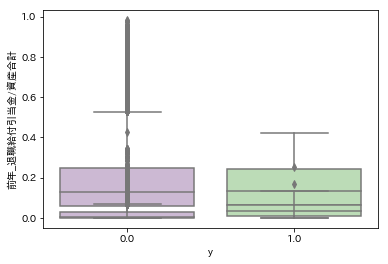

In [46]:
#グラフ表示
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

d_list = test_data.columns.values
print(d_list)

# for i in d_list:
#     test_data[i] = test_data[i].astype(float)
#     sns.boxplot( x="y", y=i, data=test_data, palette="PRGn")

sns.boxplot( x="y", y='前年_退職給付引当金/資産合計', data=test_data, palette="PRGn")
    
    

In [51]:
#分析はここから
#必要なライブラリのインポート
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from matplotlib.font_manager import FontProperties
from sklearn import datasets



['資産合計' '前年_現預金/資産合計' '前年_現預金+短期貸付金+預け金/資産合計' '前年_運転資金/資産合計'
 '前年_現預金+短期貸付金+預け金+運転資金/資産合計' '前年_退職給付引当金/資産合計' '前年_前払年金費用/資産合計']
Optimization terminated successfully.
         Current function value: 0.046972
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                17745
Model:                          Logit   Df Residuals:                    17739
Method:                           MLE   Df Model:                            5
Date:                Mon, 07 Jan 2019   Pseudo R-squ.:                  -1.138
Time:                        23:22:46   Log-Likelihood:                -833.52
converged:                       True   LL-Null:                       -389.86
                                        LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

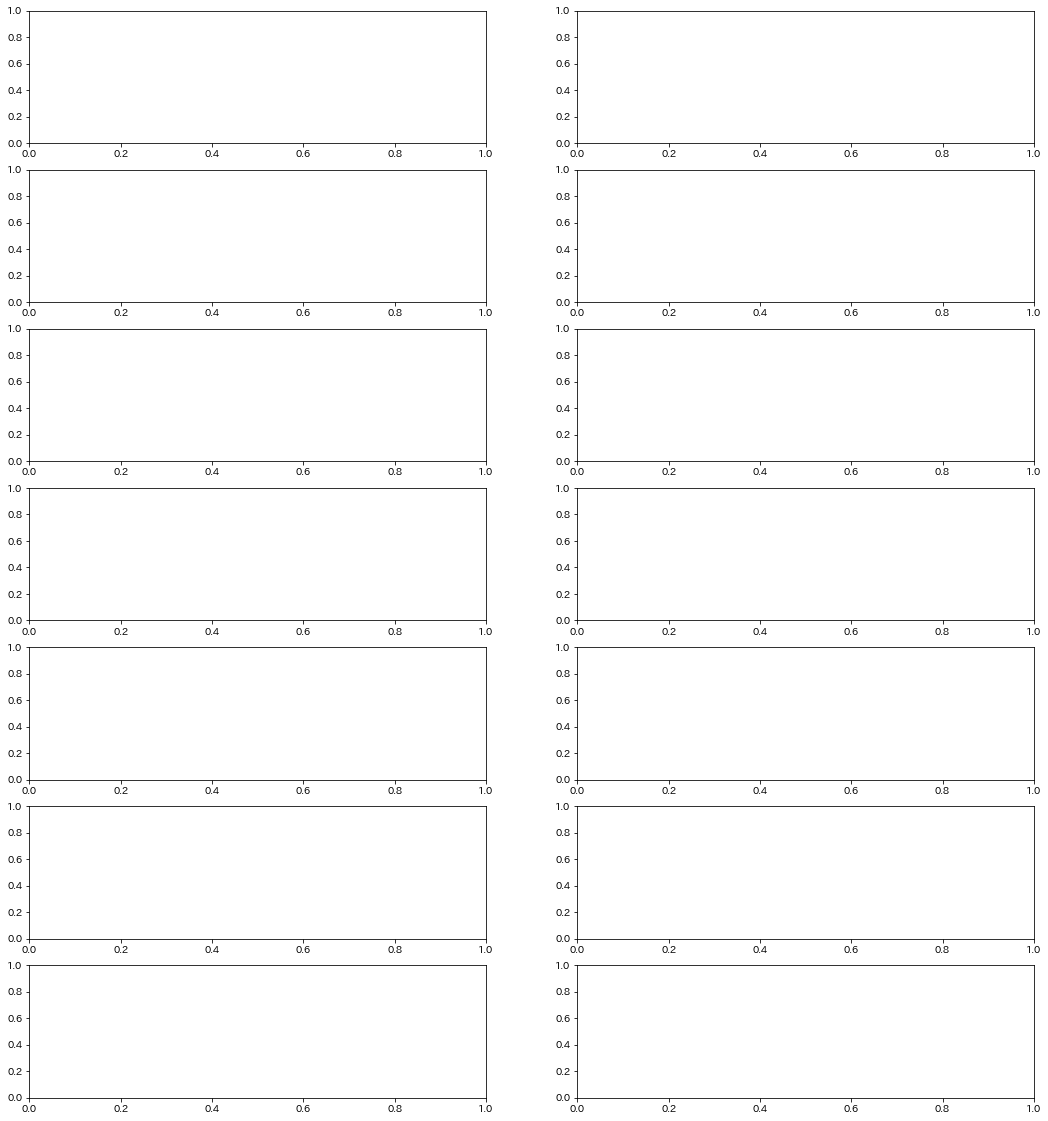

In [52]:
#数値データを指定 
num_col = test_data.drop("y", axis = 1).columns.values
print(num_col)

fig, axes = plt.subplots(nrows = len(num_col), ncols = 2, figsize = (18, 20))
 
# for x in num_col:
#     freqs = pd.crosstab(test_data[x], test_data["y"]) #出現頻度データを作成
#     freqs.plot(ax = axes[num_col.index(x), 0], kind = 'area') #左カラムにプロット
#     props = freqs.div(freqs.sum(1).astype(float), axis = 0) #出現頻度データから割合（100%）データを作成
#     props.plot(ax = axes[num_col.index(x), 1], kind = 'area') #右カラムにプロット

#     fig.tight_layout()
# plt.show()

#選択する変数の設定（ここでは全部）
selected_features = num_col

#RFEから選択された変数だけのデータに整理する
selected_X = test_data[selected_features]
 
#モデルを推定する
logit_model = sm.Logit(test_data["y"], selected_X)
result = logit_model.fit()
print(result.summary())

In [53]:
#ロジスティック変換の逆変換（ロジット表現から確率表現へ）
logit = 2.872
p = math.exp(logit) / (1 + math.exp(logit))
print(p) #事象が発生する確率

0.946444812614294
